In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow import lite


import cv2
import os
import pandas as pd

In [8]:
df = pd.read_csv('log.csv')

In [9]:
df.loc[df['Accelerate'] < 20, 'Accelerate'] = 0

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import random


#### STEP 1 - INITIALIZE DATA
def getName(filePath):
    myImagePathL = filePath.split('/')[-2:]
    myImagePath = os.path.join(myImagePathL[0],myImagePathL[1])
    return myImagePath

def importDataInfo(path):
    columns = ['Center','Steering']
    noOfFolders = len(os.listdir(path))//2
    data = pd.DataFrame()
    for x in range(17,22):
        dataNew = pd.read_csv(os.path.join(path, f'log_{x}.csv'), names = columns)
        print(f'{x}:{dataNew.shape[0]} ',end='')
        #### REMOVE FILE PATH AND GET ONLY FILE NAME
        #print(getName(data['center'][0]))
        dataNew['Center']=dataNew['Center'].apply(getName)
        data =data.append(dataNew,True )
    print(' ')
    print('Total Images Imported',data.shape[0])
    return data

#### STEP 2 - VISUALIZE AND BALANCE DATA
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin =  300
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Data Visualisation')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Balanced Data')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    return data

#### STEP 3 - PREPARE FOR PROCESSING
def loadData(path, data):
    imagesPath = []
    steering = []
    speed = []
    
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        imagesPath.append(os.path.join(path, indexed_data[0]))
        steering.append(float(indexed_data[1]))
        speed.append(float(indexed_data[2]))  # Assuming the third column in `data` contains the speed values
    
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    speed = np.asarray(speed)
    
    return imagesPath, steering, speed



#### STEP 5 - AUGMENT DATA
def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.5, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = 76-steering
    return img, steering

# imgRe,st = augmentImage('DataCollected/IMG18/Image_1601839810289305.jpg',0)
# #mpimg.imsave('Result.jpg',imgRe)
# plt.imshow(imgRe)
# plt.show()

#### STEP 6 - PREPROCESS
def preProcess(img):
    # img = img[54:120,:,:]
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = img[54:120, :]
    
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

# imgRe = preProcess(mpimg.imread('DataCollected/IMG18/Image_1601839810289305.jpg'))
# # mpimg.imsave('Result.jpg',imgRe)
# plt.imshow(imgRe)
# plt.show()

#### STEP 7 - CREATE MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def createModel():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(66, 200, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2)
    ])

    model.compile(Adam(learning_rate=0.0001),loss='mse')
    return model

#### STEP 8 - TRAINNING
def dataGen(imagesPath, steeringList, speedList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []
        speedBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering, speed = augmentImage(imagesPath[index], steeringList[index], speedList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
                speed = speedList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
            speedBatch.append(speed)
        
        yield np.asarray(imgBatch), [np.asarray(steeringBatch), np.asarray(speedBatch)]


In [ ]:
data

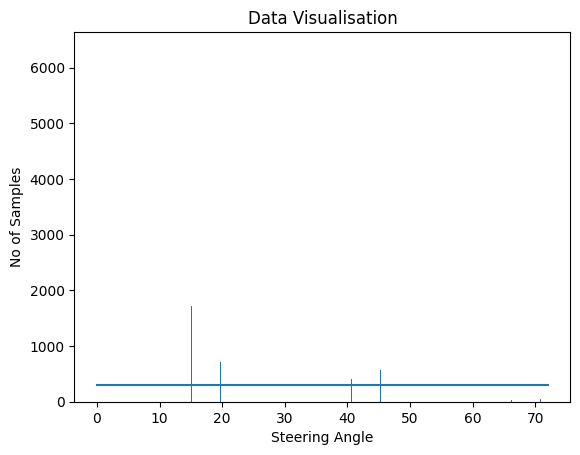

Removed Images: 15406
Remaining Images: 7097


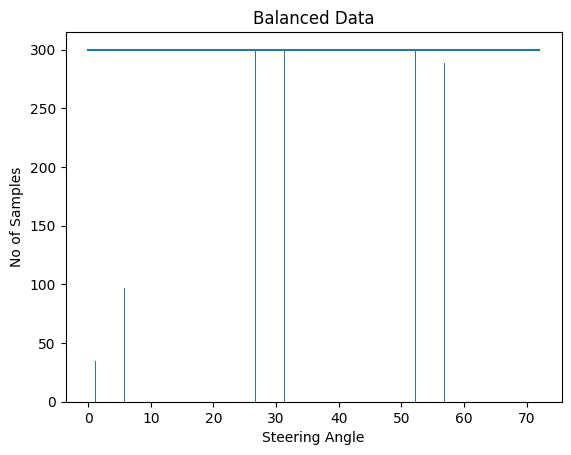

C:\Users\moustapha\AppData\Local\Temp\ipykernel_6688\294232441.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imagesPath.append( os.path.join(path,indexed_data[0]))
C:\Users\moustapha\AppData\Local\Temp\ipykernel_6688\294232441.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[1]))


Total Training Images:  5677
Total Validation Images:  1420


In [11]:
data = balanceData(df, display=True)
imagesPath, steerings, speed = loadData('./', data)
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings,test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))


In [13]:
model = createModel()

history = model.fit(dataGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=100,
                                  epochs=100,
                    
                                  validation_data=dataGen(xVal, yVal, 50, 0),
                                  validation_steps=50)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 850ms/step - loss: 1050.4032 - val_loss: 309.4000
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 691ms/step - loss: 169.6752 - val_loss: 147.9540
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 661ms/step - loss: 101.8636 - val_loss: 113.9147
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 729ms/step - loss: 86.6927 - val_loss: 95.4966
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 668ms/step - loss: 85.1384 - val_loss: 65.5891
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 623ms/step - loss: 77.3507 - val_loss: 89.5991
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 750ms/step - loss: 74.6138 - val_loss: 57.7795
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 675ms/step - loss: 68.9249 - val_loss: 64.4134
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 710ms/step - loss: 67.7164 - val_loss: 57.5757
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 718ms/step - loss: 67.1000 - val_loss: 56.3376
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - loss: 61.5634

In [16]:
model.save(f'autonomous3.keras')
converter = lite.TFLiteConverter.from_keras_model(model)
tflitemodel = converter.convert()

with open('autonomous3.tflite', 'wb') as f:
    f.write(tflitemodel)

print("Model saved")

INFO:tensorflow:Assets written to: C:\Users\MOUSTA~2\AppData\Local\Temp\tmpv26nl4ti\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSTA~2\AppData\Local\Temp\tmpv26nl4ti\assets


Saved artifact at 'C:\Users\MOUSTA~2\AppData\Local\Temp\tmpv26nl4ti'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 66, 200, 1), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1587931344736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587931344032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587931344384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587932321040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587932322976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587427083360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587931928528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587931926768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587931930288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587934089632: TensorSpec(shape=(), dtype=tf.resource, name=None)
Mod

In [19]:
history.history

{'loss': [607.0940551757812,
  144.18692016601562,
  97.93353271484375,
  83.3611068725586,
  80.85977172851562,
  76.68541717529297,
  73.02165222167969,
  68.68666076660156,
  66.95520782470703,
  64.72550201416016,
  62.16144943237305,
  63.702735900878906,
  60.32112503051758,
  60.047706604003906,
  62.35966873168945,
  60.23621368408203,
  59.86909866333008,
  58.81855010986328,
  59.24409484863281,
  56.76496124267578,
  56.409454345703125,
  57.327857971191406,
  56.25853729248047,
  56.28688049316406,
  55.340999603271484,
  55.06804275512695,
  54.9129638671875,
  55.614532470703125,
  52.637107849121094,
  52.33828353881836,
  54.069419860839844,
  52.99249267578125,
  52.056583404541016,
  52.96268081665039,
  54.13938903808594,
  51.847190856933594,
  51.693119049072266,
  50.89925765991211,
  50.270233154296875,
  49.42627716064453,
  51.800662994384766,
  50.887569427490234,
  49.94943618774414,
  51.5767822265625,
  50.42356491088867,
  50.054115295410156,
  49.05608749

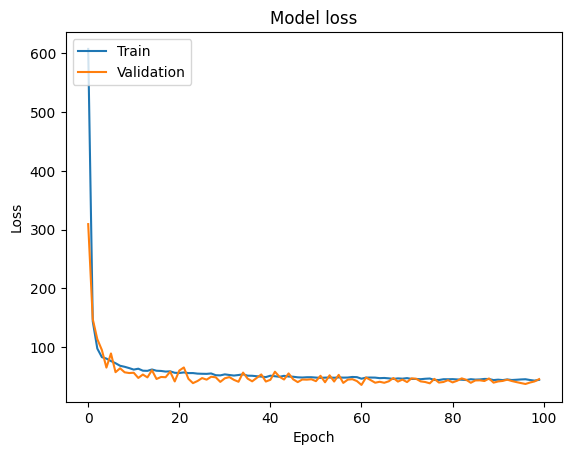

KeyError: 'mse'

In [18]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()